In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
import sys

# Below paths: bad but managable

# for our_lib
module_path = os.path.abspath(os.path.join('./our_lib')) # or the path to your source code
print(module_path)
sys.path.append(module_path)

# for recsys2025
# module_path = os.path.abspath(os.path.dirname(os.path.abspath(__file__)).join('../../.'))
module_path = os.path.abspath(os.path.join('../.')) # or the path to your source code
sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../recsys2025')) # or the path to your source code
sys.path.append(module_path)


# from our_lib import *
from our_lib import RecSysData
# from our_lib import split_data, create_baseline_embeddings, contest_training
# from our_lib import validate_and_load_embeddings

/home/zmrocze/studia/uwr/sem2/adm/projekt/src/our_lib


In [2]:
import numpy as np

# Load propensity data from .npy files
propensity_sku = np.load('../ubc_data/target/propensity_sku.npy')
propensity_category = np.load('../ubc_data/target/propensity_category.npy')

print("Propensity SKU shape:", propensity_sku.shape)
print("Propensity Category shape:", propensity_category.shape)

Propensity SKU shape: (100,)
Propensity Category shape: (100,)


In [ ]:
data = RecSysData.read_parquet('../ubc_data_sampled/')
data

RecSysData(
  add_to_cart=262119,
  page_visit=7537340,
  product_buy=84050,
  product_properties=151113,
  remove_from_cart=85482,
  search_query=480252,
  all users: 944453,
  all products: 151113
  all urls: 1528604,
)

=== SMALL DATASET STATISTICS ===

add_to_cart:
  Total interactions: 262,119
  Total users: 93,400
  Average interactions per user: 2.81
  Average interactions squared per user: 55.40
  Min interactions per user: 1
  Max interactions per user: 609
  Median interactions per user: 1.00
  Std interactions per user: 6.89
  Time range: 2022-05-23 00:19:25 to 2022-10-10 23:51:00
  Unique products: 130,268
  Product interactions: 203,612
  Product interaction sparsity: 0.9999832652685233
  Average products per user: 2.18
  Average products squared per user: 29.87
  Min products per user: 1
  Max products per user: 417
  Median products per user: 1.00
  Std products per user: 5.01

page_visit:
  Total interactions: 7,537,340
  Total users: 930,682
  Average interactions per user: 8.10
  Average interactions squared per user: 1835.68
  Min interactions per user: 1
  Max interactions per user: 10,578
  Median interactions per user: 2.00
  Std interactions per user: 42.07
  Time range: 2022-05-23

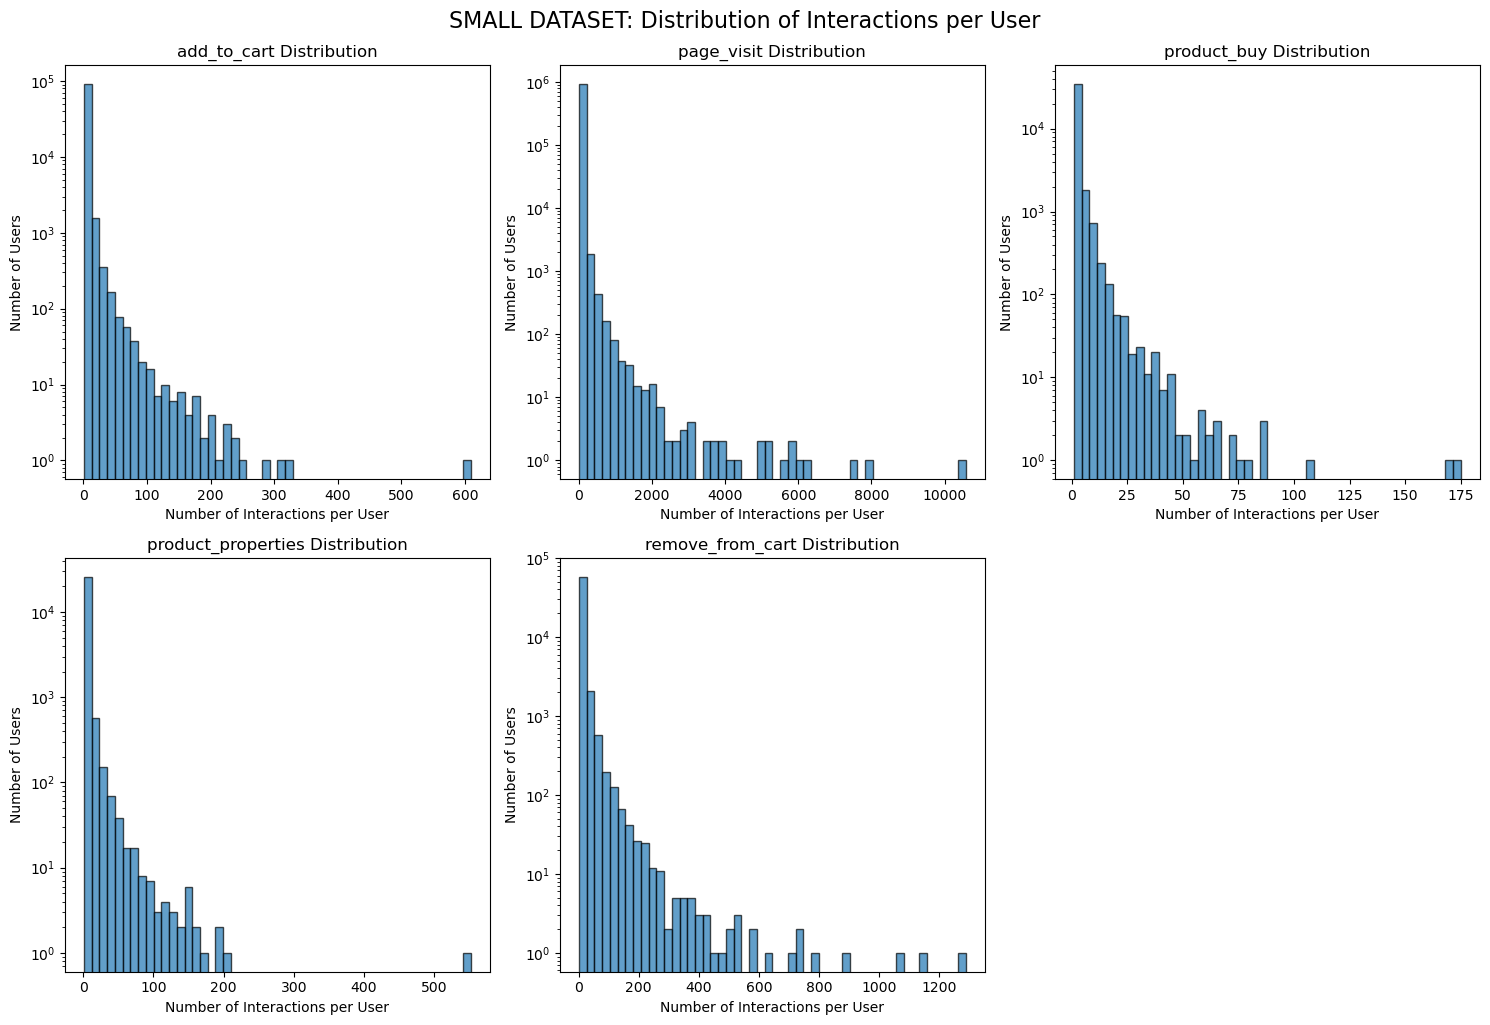

In [4]:
data.print_datasets_stats_nicely('Small dataset')

In [5]:
# Filter unique products by SKU in add_to_cart, product_buy and remove_from_cart
data.add_to_cart = data.add_to_cart.drop_duplicates(subset=['sku'])
data.product_buy = data.product_buy.drop_duplicates(subset=['sku'])
data.remove_from_cart = data.remove_from_cart.drop_duplicates(subset=['sku'])

print("After filtering unique products by SKU:")
data

After filtering unique products by SKU:


RecSysData(
  add_to_cart=130268,
  page_visit=7537340,
  product_buy=50827,
  product_properties=151113,
  remove_from_cart=54530,
  search_query=480252,
  all users: 941353,
  all products: 151113
  all urls: 1528604,
)

In [6]:
import numpy as np
import torch

# np.arrays
user_nodes = data.add_to_cart['client_id'].unique()
item_nodes = data.add_to_cart['sku'].unique()

class NodeIdMap:
  def __init__(self, users, items):
    self.id_of_user = {user: idx for idx, user in enumerate(users)}
    self.id_of_item = {item: idx + len(users) for idx, item in enumerate(items)}
    self.user_of_id = {idx: user for user, idx in self.id_of_user.items()}
    self.item_of_id = {idx: item for item, idx in self.id_of_item.items()}
    self.n_users = len(users)
    self.n_items = len(items)
    self.N = self.n_users + self.n_items

  def make_edges(self, users, items):
    user_ids = np.array([self.id_of_user[u] for u in users], dtype=np.long)
    item_ids = np.array([self.id_of_item[i] for i in items], dtype=np.long)
    return torch.tensor(np.stack((user_ids, item_ids), axis=0), dtype=torch.long)


In [7]:
import torch_geometric as tg

# self.edge_attrs = {
#         'add_to_cart': {'weight': 1.0, 'edge_type': torch.nn.functional.one_hot(torch.tensor(0), num_classes=3)},
#         'product_buy': {'weight': 5.0, 'edge_type': torch.nn.functional.one_hot(torch.tensor(1), num_classes=3)}, 
#         'remove_from_cart': {'weight': 1.0, 'edge_type': torch.nn.functional.one_hot(torch.tensor(2), num_classes=3)}
#     }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_dim = 128
dropout=0.2
heads = 8

class JustGAT(torch.nn.Module):

  def __init__(self, n, embedding_dim=embedding_dim, edge_dim=None, device=device):
    super(JustGAT, self).__init__()
    self.embedding_dim = embedding_dim
    self.edge_dim = edge_dim
    self.n = n
    self.node_embeddings = torch.nn.Embedding(self.n, embedding_dim, device=device)
    self.node_embeddings.weight.data.uniform_(-0.01, 0.01)
    # self.target_embeddings = torch.nn.Embedding(M, embedding_dim, device=device)
    # v2=True, 
    # heads, concat, residual
    self.gat = tg.nn.models.GAT(
      in_channels=self.embedding_dim, 
      hidden_channels=self.embedding_dim, 
      out_channels=None,
      num_layers=2,
      v2=True,
      dropout=dropout,
      # GATv2Conv
      heads=heads,
      residual=True,
      edge_dim=self.edge_dim,
      # concat=
    ).to(device)

  def forward(self, edge_index, edge_weight=None, edge_attr=None):
    return self.gat.forward(
      x=self.node_embeddings.weight, 
      edge_index=edge_index, 
      edge_weight=edge_weight,
      edge_attr=edge_attr
    )



# Initialize the model
model = JustGAT(10, embedding_dim=16, edge_dim=3)

edge_index = torch.tensor([[1, 1, 1, 2, 3], [0, 1, 2, 1, 3]], dtype=torch.long, device=device)
edge_weight = torch.ones(5, dtype=torch.float, device=device)
edge_attr = torch.ones(5, 3, dtype=torch.float, device=device)  # 3 edge types
print(edge_attr.shape)
# Forward pass
with torch.no_grad():
  output = model.forward(edge_index, edge_weight=edge_weight, edge_attr=edge_attr) #  edge_attr=edge_attr
  print(f"Output shapes: {output.shape}")

torch.Size([5, 3])
Output shapes: torch.Size([10, 16])


In [8]:

class RecGAT(JustGAT):
  """
    Wrapper over JustGAT that creates the graph from recommendation data.
  """
  def __init__(self, users, items, **kwargs):
    self.node_id_map = NodeIdMap(users, items)
    
    JustGAT.__init__(self, self.node_id_map.N, **kwargs)

    # self.gat = JustGAT(self.node_id_map.N, **kwargs).to(device)
    self.edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
    # self.edge_attr = torch.empty((0, self.model.edge_dim), dtype=torch.float, device=device)
    self.edge_attr = None
    # self.edge_weights = torch.empty((0, ), dtype=torch.float, device=device)
    self.edge_weight = None

  def add_edges(self, users, items, edge_attr=None, edge_weight=None):
    edge_index = self.node_id_map.make_edges(users, items).to(device=device)
    edge_index = torch.concat((self.edge_index, edge_index), dim=1)
    return self.add_edge_index(edge_index, edge_attr=edge_attr, edge_weight=edge_weight)

  def add_edge_index(self, edge_index, edge_attr=None, edge_weight=None):
    self.edge_index = edge_index
    if edge_attr is not None:
      assert self.edge_dim is not None
      self._init_edge_attr()
      self.edge_attr = torch.concat((self.edge_attr, edge_attr))
    else:
      assert self.edge_dim is None
    if edge_weight is not None:
      self._init_edge_weight()
      self.edge_weight = torch.concat((self.edge_weight, edge_weight))
    self._assert_edge_assignment()

  def _init_edge_attr(self):
    if self.edge_attr is None: self.edge_attr = torch.empty((0, self.edge_dim), dtype=torch.float, device=device)
  def _init_edge_weight(self):
    if self.edge_weight is None: self.edge_weight = torch.empty((0, ), dtype=torch.float, device=device)
  def _assert_edge_assignment(self):
    if (self.edge_attr is not None and self.edge_index.shape[1] != self.edge_attr.shape[0]) or (self.edge_weight is not None and self.edge_index.shape[1] != self.edge_weight.shape[0]):
      raise ValueError(f"Edge index, edge attr and edge weight must have the same number of edges.")

  # assumes: df['client_id'] and df['sku'] are present
  def add_edges_from_user_item_df(self, df, edge_attr=None, edge_weight=None):
    user_ids = df.client_id.values
    item_ids = df.sku.values
    self.add_edges(user_ids, item_ids, edge_attr=edge_attr, edge_weight=edge_weight)
    
  def forward(self):
    y = JustGAT.forward(self, edge_index=self.edge_index, edge_weight=self.edge_weight, edge_attr=self.edge_attr)
    # split into user and item embeddings
    user_embeddings = y[:self.node_id_map.n_users]
    item_embeddings = y[self.node_id_map.n_users:]
    return user_embeddings, item_embeddings


users = data.add_to_cart.client_id.unique()
items = data.add_to_cart.sku.unique()
model = RecGAT(users, items, embedding_dim=8, edge_dim=None)
model.add_edges_from_user_item_df(data.add_to_cart)
us, it = model.forward()
us.shape, it.shape

(torch.Size([64569, 8]), torch.Size([130268, 8]))

In [9]:
print(users[:10], items[:10])
model = RecGAT(users, items, embedding_dim=16, edge_dim=3)
edge_attrs = torch.rand((2, 3), device=device)
model.add_edges([21945667, 21945667], [1245018, 1245018], edge_attr=edge_attrs)
us, it = model.forward()
us.shape, it.shape

[21945667 10824063  3720651 13928874 15355420   932563 11309518 22894756
 17941814 14962681] [1245018 1017323  549544 1345698 1262786  347540 1455934 1083442  119053
  861509]


(torch.Size([64569, 16]), torch.Size([130268, 16]))

In [ ]:
# assumes edges have one of n types, encoded in edge_attr as one-hot vectors, predicts probability of each
# !! cant? because there can be more than one type of edge

# gives number which correlates to the edge being there or not
class DotproductEdgePredictor(torch.nn.Module):
  """
    Predicts the probability of an edge between user and item.
  """
  def __init__(self, emb_dim):
    super(DotproductEdgePredictor, self).__init__()
    self.Ws = torch.nn.Parameter(torch.Tensor(emb_dim, emb_dim))
    self.Wt = torch.nn.Parameter(torch.Tensor(emb_dim, emb_dim))
    
  def forward(self, user_emb, item_emb):
    """
      user_emb: (batch_size, emb_dim)
      item_emb: (batch_size, emb_dim)
      returns: (batch_size, )
    """
    user_proj = torch.matmul(user_emb, self.Ws)  # (batch_size, hidden_dim)
    item_proj = torch.matmul(item_emb, self.Wt)  # (batch_size, hidden_dim)
    # compute similarity
    return torch.sum(user_proj * item_proj, dim=1)  # (batch_size, )


# gives number which correlates to the edge being there or not
class LinearEdgePredictor(torch.nn.Module):
  """
    Predicts the probability of an edge between user and item. Mimicks attention score calculation in GAT. 
    a.T * relu(Ws * user_emb + Wt * item_emb) 
    Without the sigmoid !!! Important for auroc (bad), important for bpr loss (good)
  """
  def __init__(self, embedding_dim, hidden_dim=None, dropout=0.0):
    super(LinearEdgePredictor, self).__init__()
    if hidden_dim is None:
      hidden_dim = embedding_dim
    self.Ws = torch.nn.Parameter(torch.Tensor(embedding_dim, hidden_dim))
    self.Wt = torch.nn.Parameter(torch.Tensor(embedding_dim, hidden_dim))
    self.relu = torch.nn.LeakyReLU(negative_slope=0.01)
    self.a = torch.nn.Parameter(torch.Tensor(1, hidden_dim))    
    self.dropout = torch.nn.Dropout(p=dropout)
    self.init_weights()

  def init_weights(self, a = 1.0, type='normal'):
    range = (a * -1.0, a * 1.0)
    if type == 'normal':
      self.a.data.normal_(*range)
      self.Ws.data.normal_(*range)
      self.Wt.data.normal_(*range)
    elif type == 'uniform':
      self.a.data.uniform_(*range)
      self.Ws.data.uniform_(*range)
      self.Wt.data.uniform_(*range)
    else:
      raise ValueError(f"Unknown weight initialization type: {type}. Use 'normal' or 'uniform'.")

  def forward(self, user_emb, item_emb):
    """
      user_emb: (batch_size, emb_dim)
      item_emb: (batch_size, emb_dim) OR (batch_size, sample_size, emb_dim)
      returns: (batch_size, )
    """
    user_proj = torch.matmul(user_emb, self.Ws)  # (batch_size, hidden_dim)
    item_proj = torch.matmul(item_emb, self.Wt)  # (batch_size, hidden_dim)
    # compute similarity
    # print(self.dropout(self.relu(user_proj + item_proj)).shape)
    # print(self.a.shape)
    # print((torch.mm(self.dropout(self.relu(user_proj + item_proj)), self.a)).shape)

    return  torch.sum( self.a * self.dropout(self.relu(user_proj + item_proj)), axis=len(item_emb.shape)-1)   # (batch_size, 1)

def l2_reg(self, alpha=0.01):
  i=0
  total = torch.zeros((1,), device=device)
  for p in self.parameters():
    total += (p ** 2).mean()
    i += 1
  total /= i
  return total

In [11]:
# TODO: figure out how to not leak negative edges into test
#       Do we gotta use these torch geometric things?
def train_test_split_pos_edges(edge_index, test_size=0.2, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)
  
  num_edges = edge_index.shape[1]
  num_test = int(num_edges * test_size)

  indices = np.random.permutation(num_edges)
  test_indices = indices[:num_test]
  train_indices = indices[num_test:]

  return edge_index[:, train_indices], edge_index[:, test_indices]

def int_tensor(np_array, device):
  return torch.tensor(np_array, dtype=torch.long, device=device)

class BprLossLoader:
  """
    Loads batches of positive and negative edges (just random) for BPR loss.
    Uses edge_index to sample negative edges.
  """
  def __init__(self, edge_index, trg_index_range, batch_size=256, neg_samples=1, random_state=None, device=device):
    self.edge_index = edge_index
    self.batch_size = batch_size
    self.neg_samples = neg_samples
    self.random_state = random_state
    self.device = device
    self.num_edges = edge_index.shape[1]
    self.target_index_range = trg_index_range  # range of indices to sample target endpoints for negative (nonexisting) edges
    self.indices = np.arange(self.num_edges)
  
  def __iter__(self):
    if self.random_state is not None:
      np.random.seed(self.random_state)
    
    np.random.shuffle(self.indices)
    
    for start in range(0, self.num_edges, self.batch_size):
      end = min(start + self.batch_size, self.num_edges)
      pos_indices = self.indices[start:end]
      # pos_edges = self.edge_index[:, pos_indices]
      src_node = self.edge_index[0, pos_indices]
      pos_trg_node = self.edge_index[1, pos_indices]
      neg_trg_node = self.target_index_range[0] + np.random.choice( 
          self.target_index_range[1] - self.target_index_range[0] ,
          size=(self.neg_samples * pos_indices.shape[0],), replace=True
        )
      
      yield src_node.to(device=self.device), \
            pos_trg_node.to(device=self.device), \
            int_tensor(neg_trg_node, device=self.device).view(-1, self.neg_samples)
  
  def __len__(self):
    return (self.num_edges + self.batch_size - 1) // self.batch_size  # ceil division

In [12]:
# TODO: need to consider negative sampling here already not to spoil test set (will be pooling negative from all, in test the same)
def train_test_edge_split(data):
  transform = tg.transforms.RandomLinkSplit(
    num_val=0.0,  # 10% for validation
    num_test=0.2,  # 20% for testing
    # is_undirected=True # suposedly ignored for bipartite
    )
  train_data, val_data, test_data = transform(data)
  return train_data, val_data, test_data

def create_edge_data(n, edge_index, edge_attr=None, edge_weight=None):
  return tg.data.Data(
    x = torch.zeros((n, 1)), # to notify of all node ids (?)
    # x = None,
    edge_index = edge_index,
    edge_attr = edge_attr,
    edge_weight = edge_weight,
    # y = None,
    # time = timestamp # (num_edges, )
  )

def create_neighbour_loader(data):
  return tg.loader.LinkNeighbourLoader(
      data=data,
      num_neighbours=-1,
      neg_sampling = "triplet",
      replace = False,
      input_nodes=None, # or torch.LongTensor or torch.BoolTensor with node ids to use
      batch_size=256,  # number of nodes to sample per batch
      shuffle=True,  # whether to shuffle the nodes
    )

def unique_edges(df):
  """
    Returns a DataFrame with unique edges from the given DataFrame.
    Assumes df has 'client_id' and 'sku' columns.
  """
  return df.drop_duplicates(subset=['client_id', 'sku']).reset_index(drop=True)


In [13]:
unique_add_to_cart = unique_edges(data.add_to_cart)
print(unique_add_to_cart.head())

users = unique_add_to_cart['client_id'].unique()
items = unique_add_to_cart['sku'].unique()
print(items, users)

recgat = RecGAT(users, items, embedding_dim=16)
all_edge_index = recgat.node_id_map.make_edges(unique_add_to_cart.client_id.values, unique_add_to_cart.sku.values)
N = recgat.node_id_map.N
print("all_edge_index.shape", all_edge_index.shape)

train_edges, test_edges = train_test_split_pos_edges(all_edge_index, test_size=0.3, random_state=42)
print("train_edges.shape", train_edges.shape)
train_loader = BprLossLoader(
    edge_index=train_edges, 
    trg_index_range=(recgat.node_id_map.n_users, recgat.node_id_map.N), 
    batch_size=256, 
    neg_samples=50,
    random_state=42,
    device=device
)

test_loader = BprLossLoader(
  edge_index=test_edges, 
  trg_index_range=(recgat.node_id_map.n_users, recgat.node_id_map.N), 
  batch_size=1024, 
  neg_samples=50,
  random_state=42,
  device=device
)


   client_id            timestamp      sku
0   21945667  2022-06-21 09:10:45  1245018
1   21945667  2022-06-21 09:13:10  1017323
2   10824063  2022-06-15 05:25:00   549544
3   10824063  2022-06-15 05:26:25  1345698
4   10824063  2022-06-15 05:28:00  1262786
[1245018 1017323  549544 ...  699334 1318859 1086655] [21945667 10824063  3720651 ...  8558341  4723380  5898945]
all_edge_index.shape torch.Size([2, 130268])
train_edges.shape torch.Size([2, 91188])


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchmetrics as tm

def loss_f(gat, edge_predictor, pos_scores, neg_scores, l2_r=0.01):
  bpr_loss = torch.nn.functional.logsigmoid(pos_scores - neg_scores).mean()
  loss = - bpr_loss + l2_reg(gat.node_embeddings, alpha=l2_r) + l2_reg(gat, alpha=l2_r) + l2_reg(edge_predictor, alpha=l2_r)
  return loss

# to calculate AUROC we need a matrix (users, 100) of 1s and 0s whether edge is or isnt
# we have list of edges. better do this once, not vectorized
def create_target_from_edge_index(node_id_map, n_users, propensity_items, edge_index):
  ind = { sku : i for i, sku in enumerate(propensity_items) }
  target = torch.zeros((n_users, len(ind)), dtype=torch.int, device=device) # (n_users, 100)
  j = 0
  for i in range(edge_index.shape[1]):
    user_id = edge_index[0, i].item()
    item = node_id_map.item_of_id[edge_index[1, i].item()]
    if item in ind:
      j+=1
      print(f"Adding {j}th edge {user_id}, {item} to target")
      target[user_id, ind[item]] = 1
  return target

class BprTraining(pl.LightningModule):
  def __init__(self, recgat, edge_predictor, lr=0.001, propensity_sku=propensity_sku, full_test_target=None):
    super(BprTraining, self).__init__()
    self.recgat = recgat
    self.changed = True
    self._val_auroc_target = None
    self.edge_predictor = edge_predictor
    self.propensity_sku = propensity_sku
    self.lr = lr
    self.full_test_target = full_test_target

  def get_final_layer_embeddings(self):
    if self.changed:
      user_emb, item_emb = self.recgat.forward()
      self._user_emb = user_emb
      self._item_emb = item_emb
      self.changed = False
    
    return self._user_emb, self._item_emb

  # calculate (based on val_loader) only first time its needed
  def get_val_auroc_target(self, user_id, item_id):
    if self._val_auroc_target is None:
      edge_index = torch.stack((user_id, item_id))
      self._val_auroc_target = create_target_from_edge_index(self.recgat.node_id_map, self.recgat.node_id_map.n_users, self.propensity_sku, edge_index)
    return self._val_auroc_target
    

  def optimizer_step(self, *args, **kwargs):
    self.changed = True # record that gat has to be recomputed
    return super().optimizer_step(*args, **kwargs)

  def training_step(self, batch, batch_idx):
    src_node, pos_trg_node, neg_trg_node = batch
    pos_scores = self.forward(src_node, pos_trg_node).view(-1, 1)
    neg_scores = self.forward(src_node.view(-1, 1), neg_trg_node)
    loss = loss_f(self.recgat, self.edge_predictor, pos_scores, neg_scores)

    self.log('train_loss', loss)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.001)
  
  def validation_step(self, batch, batch_idx):
    src_node, pos_trg_node, neg_trg_node = batch
    pos_scores = self.forward(src_node, pos_trg_node).view(-1, 1)
    neg_scores = self.forward(src_node.view(-1, 1), neg_trg_node)
    loss = loss_f(self.recgat, self.edge_predictor, pos_scores, neg_scores)

    # auroc = self.auroc_on_propensity(self.get_val_auroc_target(src_node, pos_trg_node)) # just pos_trg_node !
    
    if self.full_test_target is not None:
      full_auroc = self.auroc_on_propensity(self.full_test_target)
      self.log("val_propensity_auroc", full_auroc)

    self.log("val_loss", loss)
    return loss

  # helpers

  def reinit_weights(self, a=1.0, type='normal'):
    self.recgat.reset_weights()
    self.edge_predictor.init_weights(a=a, type=type)
  
  # returns scores
  # item_id : node id of item node (therefore "- n_users")
  def forward(self, user_id, item_id):
    user_emb, item_emb = self.get_final_layer_embeddings()
    batch_user_emb = user_emb[user_id]
    batch_item_emb = item_emb[item_id - self.recgat.node_id_map.n_users]
    scores = self.edge_predictor(batch_user_emb, batch_item_emb)
    return scores  # (batch_size, item_id.shape[1])

  # metrics: 

  # Auroc for users (defaul all) on given items (default all), given binary target from test (say 14 days into future)
  def auroc_on_propensity(self, target_edge_index):
    print(f"1s: {target_edge_index.sum()}, shape: {target_edge_index.shape}")

    # print(f"1s: {.sum()}, shape: {self._val_auroc_target.shape}")
    propensity_item_id = torch.tensor([ self.recgat.node_id_map.id_of_item[sku] for sku in self.propensity_sku ], dtype=torch.long, device=device)
    user_id = torch.arange(0, self.recgat.node_id_map.n_users, dtype=torch.long, device=device)  # all users
    # repeat calculation from validation_step but for smaller item set so ignoring
    scores = self.forward(user_id.view(-1, 1), propensity_item_id)
    return tm.AUROC(task="binary")(scores, target_edge_index)
    # return torch.zeros((1,), device=device)  # TODO: implement AUROC calculation

In [15]:
# Get 300 random items that added to cart at least one item in test set (so that target is not all 0s)
n_sample_items = min(300, len(items))
items_with_edge = np.array(list(set( (recgat.node_id_map.item_of_id[i.item()] for i in set(test_edges[1, :]) ))), dtype=np.long)
sampled_items = np.random.choice(items_with_edge, n_sample_items, replace=False)
# create target for AUROC calculation
full_test_target = create_target_from_edge_index(
    recgat.node_id_map,
    recgat.node_id_map.n_users, 
    sampled_items, 
    test_edges
)
print("Full test target shape:", full_test_target.shape)
print("Full test target 1s:", full_test_target.sum())

Adding 1th edge 22227, 1068925 to target
Adding 2th edge 33196, 39720 to target
Adding 3th edge 15977, 939092 to target
Adding 4th edge 36969, 1166825 to target
Adding 5th edge 40072, 1376367 to target
Adding 6th edge 45563, 1034311 to target
Adding 7th edge 1389, 1333414 to target
Adding 8th edge 31127, 398794 to target
Adding 9th edge 57947, 523561 to target
Adding 10th edge 5380, 140474 to target
Adding 11th edge 23204, 25441 to target
Adding 12th edge 8251, 1494417 to target
Adding 13th edge 27912, 1066281 to target
Adding 14th edge 26883, 1307625 to target
Adding 15th edge 47129, 1415073 to target
Adding 16th edge 62997, 84791 to target
Adding 17th edge 28617, 447896 to target
Adding 18th edge 34883, 1053362 to target
Adding 19th edge 25050, 635198 to target
Adding 20th edge 5129, 879252 to target
Adding 21th edge 21372, 422450 to target
Adding 22th edge 27513, 457315 to target
Adding 23th edge 25671, 807901 to target
Adding 24th edge 37346, 686680 to target
Adding 25th edge 33150

In [16]:
test_edges

tensor([[ 64300,  51604,   4388,  ...,  59891,  35718,  51695],
        [194194, 170403,  74232,  ..., 185976, 138778, 170628]])

In [17]:

def make_model():
  embedding_dim = 16
  edge_dim = 3
  recgat = RecGAT(users, items, embedding_dim=embedding_dim, edge_dim=edge_dim, device=device)
  recgat.add_edge_index(train_edges, edge_attr=torch.zeros((train_edges.shape[1], 3), device=device))
  edge_predictor = LinearEdgePredictor(embedding_dim=embedding_dim, dropout=0.2)
  # sampled_items = np.random.choice(items, size=300, replace=False) # we dont have all items in our 5% dataset
  model = BprTraining(
      recgat=recgat,
      edge_predictor=edge_predictor,
      lr=0.001,
      propensity_sku=sampled_items,
      full_test_target=full_test_target,
    )
  model = remake_model_if_loss_nan(model)
  return model

def remake_model_if_loss_nan(model):
  # Take 4096 random user and item indices for testing
  n_test = min(4096, model.recgat.node_id_map.n_users, model.recgat.node_id_map.n_items)
  user_indices = np.random.choice(model.recgat.node_id_map.n_users, size=n_test)
  item_indices = np.random.choice(model.recgat.node_id_map.n_items, size=n_test)
  test_user_emb = model.recgat.node_embeddings.weight[user_indices]
  test_item_emb = model.recgat.node_embeddings.weight[model.recgat.node_id_map.n_users + item_indices]

  loss = loss_f(model.recgat, model.edge_predictor, test_user_emb, test_item_emb)
  while torch.isnan(loss) or torch.isneginf(loss) or torch.isinf(loss) or (loss.abs().item() > 10000.0):
    print("loss nan, trying out parameter reinitialization")
    model.reinit_weights()
    loss = loss_f(model.recgat, model.edge_predictor, test_user_emb, test_item_emb)
  return model

model = make_model()
wandb_logger = WandbLogger(project="recsys2025", name="recgat_bpr_5per")

trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=1
                     , logger=wandb_logger
                     )

# print("test_loader", test_loader)
# print("test_edges.shape", test_edges.shape)

wandb_logger.watch(model, log="all")
trainer.fit(model, train_loader, val_dataloaders=test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: zmrocze (zmrocze-uniwroc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | recgat         | RecGAT              | 3.1 M  | train
1 | edge_predictor | LinearEdgePredictor | 528    | train
---------------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.479    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

Validation: |          | 0/? [00:00<?, ?it/s]

1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: torch.Size([64569, 300])
1s: 300, shape: 

`Trainer.fit` stopped: `max_epochs=10` reached.


### how does this edge loader work?? lets try

In [18]:

unique_add_to_cart = unique_edges(data.add_to_cart)
print(unique_add_to_cart.head())

users = unique_add_to_cart['client_id'].unique()
items = unique_add_to_cart['sku'].unique()
print(items, users)

recgat = RecGAT(users, items, embedding_dim=16)
all_edge_index = recgat.node_id_map.make_edges(unique_add_to_cart.client_id.values, unique_add_to_cart.sku.values)
N = recgat.node_id_map.N

print("all_edge_index.shape", all_edge_index.shape, "N", N, "N^2", N**2, "bipartite max edges: ", len(users) * len(items))

edge_data = create_edge_data(
  n=N,
  edge_index=all_edge_index,
  edge_attr=None,
  edge_weight=None
)

# Split into train and test
train_edges, val_edges, test_edges = train_test_edge_split(edge_data)

print(f"All edges data: {edge_data}")
print(f"Train edges: {train_edges}")
print(f"Test edges: {test_edges}")
print(f"Validation edges: {val_edges}")

   client_id            timestamp      sku
0   21945667  2022-06-21 09:10:45  1245018
1   21945667  2022-06-21 09:13:10  1017323
2   10824063  2022-06-15 05:25:00   549544
3   10824063  2022-06-15 05:26:25  1345698
4   10824063  2022-06-15 05:28:00  1262786
[1245018 1017323  549544 ...  699334 1318859 1086655] [21945667 10824063  3720651 ...  8558341  4723380  5898945]
all_edge_index.shape torch.Size([2, 130268]) N 194837 N^2 37961456569 bipartite max edges:  8411274492
All edges data: Data(x=[194837, 1], edge_index=[2, 130268])
Train edges: Data(x=[194837, 1], edge_index=[2, 104215], edge_label=[208430], edge_label_index=[2, 208430])
Test edges: Data(x=[194837, 1], edge_index=[2, 104215], edge_label=[52106], edge_label_index=[2, 52106])
Validation edges: Data(x=[194837, 1], edge_index=[2, 104215], edge_label=[0], edge_label_index=[2, 0])


In [19]:
def check_edge_labels(edges_data, data_name):
  """
  Check unique values in edge_label for given edges data.
  """
  if hasattr(edges_data, 'edge_label') and edges_data.edge_label is not None:
    unique_labels = torch.unique(edges_data.edge_label)
    print(f"{data_name} edge_label unique values: {unique_labels}")
    print(f"{data_name} edge_label shape: {edges_data.edge_label.shape}")
    # Count occurrences of each label
    for label in unique_labels:
      count = torch.sum(edges_data.edge_label == label).item()
      print(f"  Label {label.item()}: {count} occurrences")
  else:
    print(f"{data_name} has no edge_label attribute or it's None")
  print()

# Check edge labels for all splits
check_edge_labels(train_edges, "Train")
check_edge_labels(test_edges, "Test") 
check_edge_labels(val_edges, "Validation")

Train edge_label unique values: tensor([0., 1.])
Train edge_label shape: torch.Size([208430])
  Label 0.0: 104215 occurrences
  Label 1.0: 104215 occurrences

Test edge_label unique values: tensor([0., 1.])
Test edge_label shape: torch.Size([52106])
  Label 0.0: 26053 occurrences
  Label 1.0: 26053 occurrences

Validation edge_label unique values: tensor([])
Validation edge_label shape: torch.Size([0])



In [20]:
class BipartiteData(tg.data.Data):
  def __init__(self, edge_index, x_s, x_t):
    super(BipartiteData, self).__init__()
    self.edge_index = edge_index
    self.x_s = x_s
    self.x_t = x_t

  def __inc__(self, key, value):
    if key == 'edge_index':
      return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
    else:
      return super(self).__inc__(key, value)

edge_index = torch.tensor([
    [0, 0, 1, 1],
    [0, 1, 1, 2],
])
x_s = torch.randn(2, 16)  # 2 nodes.
x_t = torch.randn(3, 16)  # 3 nodes.

data = BipartiteData(edge_index, x_s, x_t)
data_list = [data, data]
loader = tg.loader.DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

print(batch)
# Batch(edge_index=[2, 8], x_s=[4, 16], x_t=[6, 16])

print(batch.edge_index)
# >>> tensor([[0, 0, 1, 1, 2, 2, 3, 3],
            # [0, 1, 1, 2, 3, 4, 4, 5]])

TypeError: BipartiteData.__inc__() takes 3 positional arguments but 4 were given

In [ ]:
silly_small_graph_data = create_edge_data(10, 
    torch.tensor([[0, 1, 1, 1, 2, 3], [5, 5, 6, 7, 5, 8]], dtype=torch.long)
    )

edge_data = silly_small_graph_data

train_edges, val_edges, test_edges = tg.transforms.RandomLinkSplit(
    num_val=0.0,  # 10% for validation
    num_test=0.2,  # 20% for testing
    # is_undirected=True # suposedly ignored for bipartite

    )(edge_data)

check_edge_labels(train_edges, "Train")
check_edge_labels(test_edges, "Test") 
# check_edge_labels(val_edges, "Validation")

def try_loader(data):
    loader = tg.loader.LinkNeighborLoader(
        data=data,
        num_neighbors= [-1 for _ in range(data.x.shape[0])],
        neg_sampling = "triplet",
        replace = False,
        batch_size=256,  # number of nodes to sample per batch
        shuffle=True,  # whether to shuffle the nodes
    )
    for batch in loader:
        print(f"Batch: {batch}")
        print(f"n_id {batch.n_id}")
        # print(f"input_id {batch.input_id}")
        print(f"Batch edge index: {batch.edge_index}")
        print(f"src_index: {batch.src_index}")
        print(f"dst_pos: {batch.dst_pos_index}") 
        print(f"dst_neg: {batch.dst_neg_index}")

# Try the loader on train edges
print("Trying loader on train edges:")
try_loader(train_edges)
# Try the loader on test edges
print("Trying loader on test edges:")
try_loader(test_edges)


In [ ]:
# edg = torch.tensor([[0, 1, 1], [0, 1, 2]], dtype=torch.long)
# a = tg.utils.negative_sampling(edge_index=edg, num_nodes=(2, 3))
# a

In [ ]:
for x in edge_data.edge_index:
  print(x)
print(all_edge_index)
print(edge_data.edge_index.shape)

In [ ]:
for x in test_edges.edge_index:
  print(x)

print(test_edges.edge_index.shape)
print(train_edges.edge_index.shape)

In [ ]:
# labels?
print("train_edges.edge_label: ")
for x in train_edges.edge_label[:10]:
  if x.item == 0.0:
    print(x)
print("train_edges.edge_label_index: ")
for x in train_edges.edge_label_index[:10]:
  print(x)
print("test_edges.edge_label: ")
for x in test_edges.edge_label[:10]:
  print(x)
print("test_edges.edge_label_index: ")
for x in test_edges.edge_label_index[:10]:
  print(x)
print(train_edges.edge_label.shape)
print(train_edges.edge_label_index.shape)
print(test_edges.edge_label.shape)
print(test_edges.edge_label_index.shape)


In [ ]:
BPRLoss = tg.nn.models.lightgcn.BPRLoss

class SomeModel(torch.nn.Module):
  def __init__(self, recgat, edge_predictor, dropout=0.0):
    super(SomeModel, self).__init__()
    self.recgat = recgat
    self.edge_predictor = edge_predictor
    self.dropout = torch.nn.Dropout(p=dropout)
  
  # positive (items): (batch_size, )
  # negative (items): (batch_size, )
  def forward(self, positive, negative):
    pos_id = positive
    user_emb, item_emb = self.recgat.forward()
    user_emb = self.dropout(user_emb)
    item_emb = self.dropout(item_emb)
    edge_scores = self.edge_predictor(user_emb, item_emb)
    return edge_scores
  
  def loss(self):
